In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, assemble, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
backend = Aer.get_backend('qasm_simulator')

In [3]:
def RUS(inp, out_length):
    '''Input has to be in basis encoding (for now)'''
    
    N = len(inp)    
    
    #input or control register
    q = QuantumRegister(N, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)
    
    #ancilla register; number of ancillas depends on the number of RUS runs
    ancilla = QuantumRegister(1, 'ancilla')   
    
    #output register, depends on the bitstring length of the true value
    output = QuantumRegister(out_length, 'output')
    circ.add_register(ancilla, output)
    
    #construct the circuit
    for j in range(out_length):
        '''repeat this circuit for each output qubit'''
        
        #repeat each circuit until '0' is measured
        measurement = '1'
        repeat = 0
        
        while measurement != '0':
            for i in range(N):
                if inp[i]=='1':
                    circ.x(q[i])
            circ.barrier()

            w = np.repeat(np.pi/3, N)
            b = np.pi/3

            for i in range(N):
                circ.cry(2*w[i], q[i], ancilla)
            circ.ry(2*b, ancilla)
            circ.barrier()

            circ.cy(ancilla, output[j])
            circ.barrier()

            circ.ry(-2*b, ancilla)
            for i in reversed(range(N)):
                circ.cry(-2*w[i], q[i], ancilla)
            circ.barrier()

            circ.measure(ancilla, c)

            circ.barrier()

            job = execute(circ, backend, shots=1, memory=True)
            result = job.result()
            measurement = result.get_memory()[0]
            repeat = int(measurement)

            if repeat==1:
                circ.ry(-np.pi/2, output[j])
                circ.barrier()
    
    return circ, measurement

In [ ]:
#TODO: RUS with k=1
#TODO: training
#QuAM encoding

In [4]:
def qron(data):
    '''input in decimal representation as tuple or list'''
    
    #divide data into input features and output value
    inp = data[:-1]
    out = data[-1]
    
    #Encode into bit-string
    n = len(inp)
    N = int(np.amax(np.log2(inp)+1))
    b = []
    bitlength = '{:0'+str(N)+'b}'
    for i in range(n):
        b.append(bitlength.format(inp[i]))

    inp_bit = "".join(b)    
    out_length = int(np.log2(out)+1)
    
    result = RUS(inp_bit, out_length)
    circ, measurement = result[0], result[1]
    
    return circ

In [7]:
circ = qron((2,1,0,6,3))

/tmp/ipykernel_212/2908980997.py:10: RuntimeWarning: divide by zero encountered in log2
  N = int(np.amax(np.log2(inp)+1))


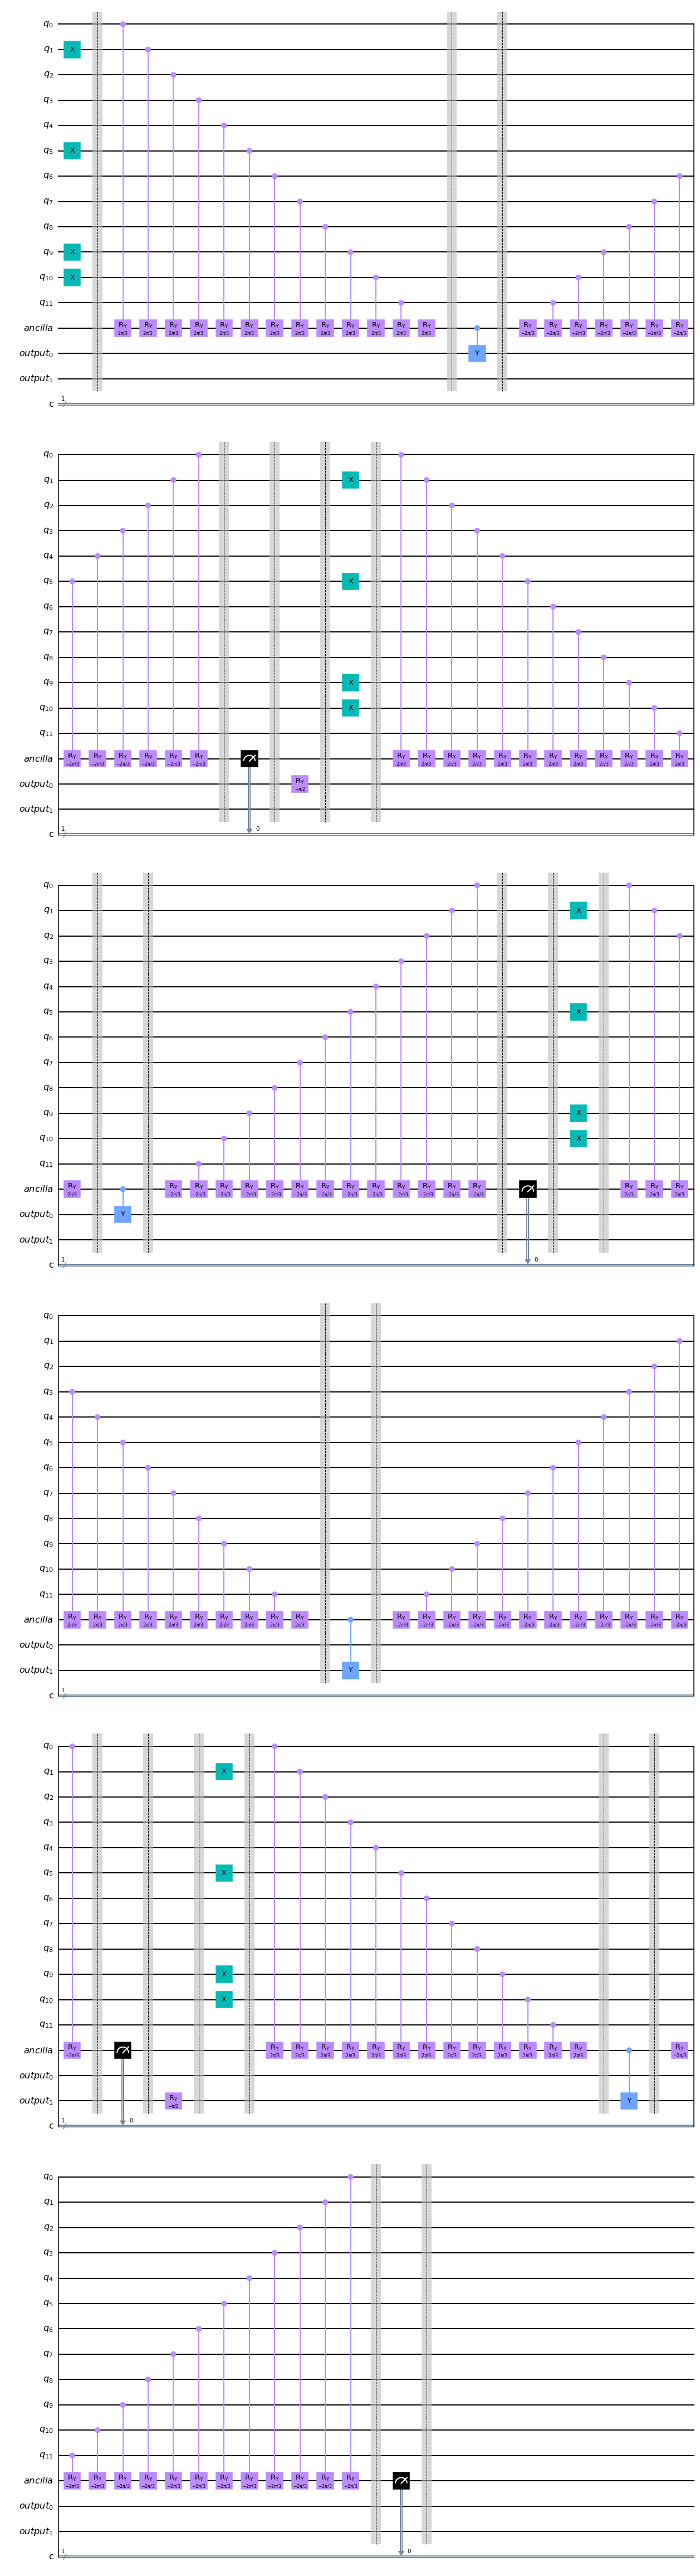

In [8]:
circ.draw()